## Imports and matplotlib options

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
import pickle

import IPython.display as ipd
import essentia
import essentia.standard as es

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

In [70]:
%pylab inline
sns.set()
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams.update({'font.size': 20})

Populating the interactive namespace from numpy and matplotlib


/home/bam/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Global settings

In [4]:
os.chdir('data')

In [5]:
sample_rate = 44100
samples_per_frame = 4096
hop_length = 2048

window_type = 'blackmanharris92'

peak_params = {'magnitudeThreshold':0.00001,
               'minFrequency':40,
               'maxFrequency':5000,
               'maxPeaks':60}

HPCP_params = {'size':36, 
                'bandPreset':False,
                'minFrequency':40,
                'maxFrequency':5000,
                'nonLinear':True,   
                'harmonics':8,
                'windowSize':1.33} 

key_params = {'profileType':'shaath',  
             'numHarmonics':8,         
             'pcpSize':36,
             'slope':0.6,
             'usePolyphony':True,
             'useThreeChords':True}

secs_per_frame = samples_per_frame / sample_rate

## Extract Features

In [6]:
def gen_frames(filepath):
    """Cuts audio into many frames"""
    # Convert file to mono raw audio
    audio = es.MonoLoader(filename=filepath, sampleRate=sample_rate)()
    
    # Cut audio into frames and expand them into windowed frames for better processing
    frame_gen = es.FrameGenerator(audio, frameSize=samples_per_frame, hopSize=hop_length)
    frames = np.array([es.Windowing(size=samples_per_frame, type=window_type)(frame)
                            for frame in frame_gen])
    
    return frames

### Spectral information

In [7]:
def get_spectral_info(frame):
    """Gets spectrum frequencies and their magnitudes for a single frame"""
    spectrum = es.Spectrum(size=samples_per_frame)(frame)
    freqs, mags = es.SpectralPeaks(**peak_params)(spectrum)
    mags = es.SpectralWhitening()(spectrum, freqs, mags)
    return spectrum, freqs, mags

### Harmonic Pitch Class Profile (HPCP)

In [8]:
def gen_frame_HPCP(spectral_info):
    """Generates HPCP for a single frame"""
    spectrum, freqs, mags = spectral_info
    return es.HPCP(**HPCP_params)(freqs, mags)

In [9]:
def gen_global_HPCP(frames):
    """Stitches together frame-based HPCPs into full HPCP"""
    return np.array([gen_frame_HPCP(get_spectral_info(frame)) for frame in frames])

### Key

In [10]:
def get_key_attrs(hpcp):
    """Gets key and scale info from HPCP"""
    return es.Key(**key_params)(np.mean(hpcp, axis=0))

### Beat ticks

In [11]:
def get_beats(filepath):
    """Gets beat locations by sample number, as well as global BPM"""
    audio = es.MonoLoader(filename=filepath, sampleRate=sample_rate)()
    return es.RhythmExtractor2013(method='multifeature')(audio)

### Scale HPCP to per-beat

In [12]:
def gen_beat_HPCP(ticks, hpcp):
    """Converts HPCP from one entry per frame to one entry per beat.
    Each entry is the average of the per-frame values in the corresponding beat interval."""
    
    # 2x adjustment needed to adjust for windowing making each frame twice as large
    frame_ticks = 2 * ticks / secs_per_frame
    
    def average_HPCP_frames(start_frame, end_frame, hpcp):
        return np.mean(hpcp[int(start_frame): int(end_frame)], axis=0)
    
    adjusted_hpcp = []
    prev_frame = 0
    for frame_num in frame_ticks:
        adjusted_hpcp.append(average_HPCP_frames(prev_frame, frame_num, hpcp))
        prev_frame = frame_num
    
    return np.array(adjusted_hpcp)

## Get features from HPCP

In [13]:
def calc_means(hpcp):
    """Arithmetic mean, geometric mean, and median for all semitones in HPCP"""
    ameans = np.mean(hpcp, axis=0)
    medians = np.median(hpcp, axis=0)
    gmeans = stats.gmean(hpcp, axis=0)
    
    return ameans, gmeans, medians

## Extract all the features for one song

In [14]:
def song_dict(filepath, semitone_offset=0, save_hpcp=False):
    """Collects all information from a single song"""
    
    # Gather all of the info
    frames = gen_frames(filepath)
    global_hpcp = gen_global_HPCP(frames)
    
    global_hpcp = np.roll(global_hpcp, semitone_offset, axis=1)
    
    key, scale, strength, rel_strength = get_key_attrs(global_hpcp)
    bpm, ticks, confidence, estimates, intervals = get_beats(filepath)
    adj_hpcp = gen_beat_HPCP(ticks, global_hpcp)
    ameans, gmeans, medians = calc_means(adj_hpcp)
    all_means = (ameans, gmeans, medians)
    
    # Format info and put into dict
    mean_names = ['amean', 'gmean', 'median']
    
    song_stats = dict()
    song_stats['title'] = filepath.split(sep='/')[-1][:-4]
    
    if len(filepath.split(sep='/')) > 1:
        song_stats['album'] = filepath.split(sep='/')[-2]
    else:
        song_stats['album'] = 'unknown'
        
    song_stats['filepath'] = filepath[:-4]
    song_stats['semitone_offset'] = semitone_offset
    song_stats['bpm'] = bpm
    song_stats['key'] = key
    song_stats['scale'] = scale
    song_stats['total_beats'] = int(adj_hpcp.shape[0])
    
    # Add means and median for each semitone
    for mean_num in range(len(mean_names)):
        for semitone in range(adj_hpcp.shape[1]):
            mean_type = mean_names[mean_num]
            song_stats['semitone_%s_%d' % (mean_type, semitone)] = all_means[mean_num][semitone]
    if save_hpcp:        
        song_stats['hpcp'] = adj_hpcp
    
    return song_stats

## Data visualization

In [15]:
def show_stats(song_stats, show_path=False):
    """Shows song information and HPCP"""
    
    if show_path:
        print('Title:', song_stats['title'])
    print('BPM:', song_stats['bpm'])
    print('Key:', song_stats['key'])
    print('Scale:', song_stats['scale'])
    
    imshow(song_stats['hpcp'].T, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
    plt.ylabel('Pitch', size=20)
    plt.xlabel('Beat Number', size=20)
    plt.title('Harmonic Pitch Class Profile\n(y==0 corresponds to the note A flat)')
    plt.grid(b=None)
    plt.show();

# [Go here to load training, validation, and test DataFrames](#Load-pickles)

# Get training/validation/test data
### TODO: Functionalize and clean

# Get all training data (will take a LONG time and about 12 gigs of RAM)

In [ ]:
for folderName, subfolders, filenames in os.walk('./prototypes'):
    print('The current folder is ' + folderName)
    album_dict = dict()
    for subfolder in subfolders:
        print('SUBFOLDER OF ' + folderName + ': ' + subfolder)
        
    for filename in filenames:
        print('FILE INSIDE ' + folderName + ': '+ filename)
        
        for offset in range(5):
            album_dict[filename[:-4] + 'offset ', str(offset - 2)] = song_dict(os.path.join(folderName, filename)
                                                                              , offset - 2)
    print('Saving', folderName, 'pickle.')
    
    with open('%s_dict.pkl' % folderName, 'wb') as f:
        pickle.dump(album_dict, f)
    
    print('')

## Compile extracted features from each album into a DataFrame

In [25]:
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [26]:
os.chdir('./training')

In [27]:
!ls

'A Momentary Lapse of Reason_dict.pkl'
 Animals_dict.pkl
'A Saucerful of Secrets_dict.pkl'
'Atom Heart Mother_dict.pkl'
 Meddle_dict.pkl
 More_dict.pkl
'Obscured by Clouds_dict.pkl'
'The Dark Side of the Moon_dict.pkl'
'The Division Bell_dict.pkl'
'The Final Cut_dict.pkl'
'The Piper at the Gates of Dawn_dict.pkl'
'The Wall_dict.pkl'
 Ummagumma_dict.pkl
'Wish You Were Here_dict.pkl'


In [28]:
with open('A Momentary Lapse of Reason_dict.pkl', 'rb') as f:
    AMLOR_dict = pickle.load(f)

In [29]:
all_songs = pd.DataFrame.from_dict(AMLOR_dict, orient='index')
file_list = !ls

In [30]:
for file in file_list[1:]:
    if file.endswith('.pkl'):
        with open(file, 'rb') as f:
            album_dict = pickle.load(f)
            all_songs = all_songs.append(pd.DataFrame.from_dict(album_dict, orient='index'), ignore_index=True)
            f.close()

all_songs.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,-1,135.759918,B,minor,219,0.015184,0.031082,...,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601
1,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,-2,135.759918,B,minor,219,0.031082,0.026377,...,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601,0.000885
2,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,0,135.759918,C,minor,219,0.009655,0.015184,...,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163
3,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,1,135.759918,C,minor,219,0.009816,0.009655,...,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131
4,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,2,135.759918,C,minor,219,0.008938,0.009816,...,0.031911,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095


In [31]:
os.chdir('../')
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [32]:
with open('all_songs.pkl', 'wb') as f:
    pickle.dump(all_songs, f)

# Get data from validation

In [68]:
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [69]:
os.chdir('./validation')

In [18]:
def conv_folder_to_pkls():
    
    for folderName, subfolders, filenames in os.walk('.'):
        print('The current folder is ' + folderName)
        album_dict = dict()
        
        for subfolder in subfolders:
            print('SUBFOLDER OF ' + folderName + ': ' + subfolder)

        for filename in filenames:
            print('FILE INSIDE ' + folderName + ': '+ filename)

            if filename.endswith('.mp3'):
                album_dict[filename[:-4]] = song_dict(os.path.join(folderName, filename))
                
        print('Saving', folderName, 'pickle.')
        with open('%s_dict.pkl' % folderName, 'wb') as f:
            pickle.dump(album_dict, f)
    
    print('All Folders Pickled')

In [83]:
conv_folder_to_pkls()

The current folder is .
SUBFOLDER OF .: 1972 - Sapporo, Japan (3-12-72)
FILE INSIDE .: 1995 - Pulse (Live)_dict.pkl
FILE INSIDE .: ._dict.pkl
FILE INSIDE .: Pepperland In The West (Disc 1)_dict.pkl
FILE INSIDE .: Pepperland In The West (Disc 2)_dict.pkl
FILE INSIDE .: 1974 - Getting Better All the Time (11-17-74)_dict.pkl
FILE INSIDE .: 1977 - Mr. Pig (Oakland, CA) 5-9-77_dict.pkl
FILE INSIDE .: 1975 - Ivor Wynne (6-28-75)_dict.pkl
FILE INSIDE .: Is There Anybody Out There (The Wall Li_dict.pkl
FILE INSIDE .: 1988 - Delicate Sound of Thunder_dict.pkl
FILE INSIDE .: Eclipse_dict.pkl
Saving . pickle.
The current folder is ./1972 - Sapporo, Japan (3-12-72)
FILE INSIDE ./1972 - Sapporo, Japan (3-12-72): Speak to Me & Breathe.mp3
FILE INSIDE ./1972 - Sapporo, Japan (3-12-72): Any Colour You Like.mp3
FILE INSIDE ./1972 - Sapporo, Japan (3-12-72): Eclipse.mp3
FILE INSIDE ./1972 - Sapporo, Japan (3-12-72): Us and Them.mp3
FILE INSIDE ./1972 - Sapporo, Japan (3-12-72): Brain Damage.mp3
FILE INS

/home/bam/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:316: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


In [84]:
os.getcwd()

'/home/bam/metis/projects/project_3/data/validation'

In [85]:
!ls

'1972 - Sapporo, Japan (3-12-72)'
'1972 - Sapporo, Japan (3-12-72)_dict.pkl'
'1974 - Getting Better All the Time (11-17-74)_dict.pkl'
'1975 - Ivor Wynne (6-28-75)_dict.pkl'
'1977 - Mr. Pig (Oakland, CA) 5-9-77_dict.pkl'
'1988 - Delicate Sound of Thunder_dict.pkl'
'1995 - Pulse (Live)_dict.pkl'
 Eclipse_dict.pkl
'Is There Anybody Out There (The Wall Li_dict.pkl'
'Pepperland In The West (Disc 1)_dict.pkl'
'Pepperland In The West (Disc 2)_dict.pkl'


In [89]:
file_list = !ls

In [90]:
with open(file_list[0], 'rb') as f:
    first_album_dict = pickle.load(f)

In [91]:
val_df = pd.DataFrame.from_dict(first_album_dict, orient='index')

In [92]:
for file in file_list[1:]:
    if file.endswith('.pkl'):
        with open(file, 'rb') as f:
            album_dict = pickle.load(f)
            val_df = val_df.append(pd.DataFrame.from_dict(album_dict, orient='index'), ignore_index=True)
            f.close()

val_df.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,Any Colour You Like,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Any Colour Y...",0,144.003738,C#,major,668,0.293824,0.055529,...,0.324724,0.144504,0.080366,0.106506,0.094481,0.055653,0.063480,0.083960,0.398189,0.817317
1,Brain Damage,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Brain Damage",0,129.090530,B,major,599,0.186995,0.068871,...,0.106510,0.100984,0.188387,0.415272,0.309805,0.139331,0.119428,0.090986,0.192458,0.362927
2,"Careful With That Axe, Eugene","1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Careful With...",0,120.015747,C#,minor,1515,0.278888,0.102913,...,0.047493,0.040973,0.095780,0.167597,0.107407,0.063285,0.077872,0.111893,0.539116,0.796482
3,Eclipse,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Eclipse",0,120.775345,C#,major,595,0.312853,0.120792,...,0.119011,0.069335,0.060718,0.080562,0.084329,0.077471,0.090600,0.091719,0.299468,0.603647
4,Money,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Money",0,123.176613,C#,major,893,0.223657,0.086578,...,0.498293,0.295483,0.105195,0.094373,0.091376,0.092304,0.118360,0.117163,0.207754,0.376693


In [93]:
os.chdir('../')
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [94]:
with open('val_df.pkl', 'wb') as f:
    pickle.dump(val_df, f)

# Get data for test

In [6]:
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [7]:
os.chdir('./test')

In [54]:
conv_folder_to_pkls()

The current folder is .
SUBFOLDER OF .: Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics
FILE INSIDE .: 1975 - Pink Floyd - live boston 1975_dict.pkl
FILE INSIDE .: ._dict.pkl
FILE INSIDE .: Live USA_dict.pkl
FILE INSIDE .: 1977 - The Perfect Day_dict.pkl
FILE INSIDE .: Interstellar Zappadrive_dict.pkl
FILE INSIDE .: 1970 - Smoking Blues_dict.pkl
FILE INSIDE .: The Darkside Rehearsals -Disc 2_dict.pkl
FILE INSIDE .: Live at Pompeii_dict.pkl
FILE INSIDE .: Pink Floyd HRV CDR 002 Colmar_dict.pkl
FILE INSIDE .: BBC - CD2_dict.pkl
FILE INSIDE .: The Darkside Rehearsals - Disc 1_dict.pkl
FILE INSIDE .: BBC - CD1_dict.pkl
Saving . pickle.
The current folder is ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Speak to Me & Breathe.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Any Colour You Like.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Pie

/home/bam/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:316: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Us and Them.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Childhood's End.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Brain Damage.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Echoes.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Set the Controls for the Heart of the Sun.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Money.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: One of These Days.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Time.mp3
FILE INSIDE ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics: Careful With That Axe, Eugene.mp3
Saving ./Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics pickle.
All Folders Pickled


In [59]:
os.getcwd()

'/home/bam/metis/projects/project_3/data/test'

In [8]:
!ls

'1970 - Smoking Blues_dict.pkl'
'1975 - Pink Floyd - live boston 1975_dict.pkl'
'1977 - The Perfect Day_dict.pkl'
'BBC - CD1_dict.pkl'
'BBC - CD2_dict.pkl'
'Interstellar Zappadrive_dict.pkl'
'Live at Pompeii_dict.pkl'
'Live USA_dict.pkl'
'Pink Floyd HRV CDR 002 Colmar_dict.pkl'
'Pink Floyd HRV CDR 004 Eclipse - A Piece For Assorted Lunatics_dict.pkl'
'The Darkside Rehearsals - Disc 1_dict.pkl'
'The Darkside Rehearsals -Disc 2_dict.pkl'


In [9]:
file_list = !ls

In [10]:
with open(file_list[0], 'rb') as f:
    first_album_dict = pickle.load(f)

In [11]:
test_df = pd.DataFrame.from_dict(first_album_dict, orient='index')

In [12]:
for file in file_list[1:]:
    if file.endswith('.pkl'):
        with open(file, 'rb') as f:
            album_dict = pickle.load(f)
            test_df = test_df.append(pd.DataFrame.from_dict(album_dict, orient='index'), ignore_index=True)
            f.close()

test_df.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,Astronomy Domine,1970 - Smoking Blues,./1970 - Smoking Blues/Astronomy Domine,0,130.013504,Ab,minor,1209,0.122071,0.134805,...,0.073287,0.069486,0.111301,0.129226,0.108101,0.120625,0.114420,0.080217,0.094867,0.111911
1,Atom Heart Mother,1970 - Smoking Blues,./1970 - Smoking Blues/Atom Heart Mother,0,135.949295,Ab,minor,2345,0.115335,0.136503,...,0.061186,0.040159,0.129429,0.197695,0.069846,0.032474,0.030095,0.027463,0.125730,0.164735
2,Cymbaline,1970 - Smoking Blues,./1970 - Smoking Blues/Cymbaline,0,123.500526,Ab,minor,1474,0.197999,0.120970,...,0.153300,0.090494,0.107763,0.201548,0.133157,0.067902,0.084559,0.090813,0.195618,0.280962
3,Fat Old Sun,1970 - Smoking Blues,./1970 - Smoking Blues/Fat Old Sun,0,146.888382,C#,minor,1928,0.130550,0.095349,...,0.020821,0.019367,0.133620,0.209203,0.061479,0.014881,0.014558,0.028366,0.268018,0.399256
4,Dogs,1975 - Pink Floyd - live boston 1975,./1975 - Pink Floyd - live boston 1975/Dogs,0,123.123215,D,minor,1749,0.193741,0.370013,...,0.125513,0.091805,0.086670,0.066470,0.089680,0.105248,0.059012,0.038518,0.042021,0.055202


In [13]:
os.chdir('../')
os.getcwd()

'/home/bam/metis/projects/project_3/data'

In [14]:
with open('test_df.pkl', 'wb') as f:
    pickle.dump(test_df, f)

# Convert dummies and do some cleaning
## TODO: Functionalize

# Load pickles

In [33]:
with open('all_songs.pkl', 'rb') as f:
    all_songs = pickle.load(f)

all_songs.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,-1,135.759918,B,minor,219,0.015184,0.031082,...,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601
1,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,-2,135.759918,B,minor,219,0.031082,0.026377,...,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601,0.000885
2,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,0,135.759918,C,minor,219,0.009655,0.015184,...,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163
3,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,1,135.759918,C,minor,219,0.009816,0.009655,...,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131
4,A New Machine (Part 1),A Momentary Lapse of Reason,./prototypes/A Momentary Lapse of Reason/A New...,2,135.759918,C,minor,219,0.008938,0.009816,...,0.031911,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095


In [34]:
with open('val_df.pkl', 'rb') as f:
    val_df = pickle.load(f)

val_df.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,Any Colour You Like,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Any Colour Y...",0,144.003738,C#,major,668,0.293824,0.055529,...,0.324724,0.144504,0.080366,0.106506,0.094481,0.055653,0.063480,0.083960,0.398189,0.817317
1,Brain Damage,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Brain Damage",0,129.090530,B,major,599,0.186995,0.068871,...,0.106510,0.100984,0.188387,0.415272,0.309805,0.139331,0.119428,0.090986,0.192458,0.362927
2,"Careful With That Axe, Eugene","1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Careful With...",0,120.015747,C#,minor,1515,0.278888,0.102913,...,0.047493,0.040973,0.095780,0.167597,0.107407,0.063285,0.077872,0.111893,0.539116,0.796482
3,Eclipse,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Eclipse",0,120.775345,C#,major,595,0.312853,0.120792,...,0.119011,0.069335,0.060718,0.080562,0.084329,0.077471,0.090600,0.091719,0.299468,0.603647
4,Money,"1972 - Sapporo, Japan (3-12-72)","./1972 - Sapporo, Japan (3-12-72)/Money",0,123.176613,C#,major,893,0.223657,0.086578,...,0.498293,0.295483,0.105195,0.094373,0.091376,0.092304,0.118360,0.117163,0.207754,0.376693


In [35]:
with open('test_df.pkl', 'rb') as f:
    test_df = pickle.load(f)

test_df.head()

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,Astronomy Domine,1970 - Smoking Blues,./1970 - Smoking Blues/Astronomy Domine,0,130.013504,Ab,minor,1209,0.122071,0.134805,...,0.073287,0.069486,0.111301,0.129226,0.108101,0.120625,0.114420,0.080217,0.094867,0.111911
1,Atom Heart Mother,1970 - Smoking Blues,./1970 - Smoking Blues/Atom Heart Mother,0,135.949295,Ab,minor,2345,0.115335,0.136503,...,0.061186,0.040159,0.129429,0.197695,0.069846,0.032474,0.030095,0.027463,0.125730,0.164735
2,Cymbaline,1970 - Smoking Blues,./1970 - Smoking Blues/Cymbaline,0,123.500526,Ab,minor,1474,0.197999,0.120970,...,0.153300,0.090494,0.107763,0.201548,0.133157,0.067902,0.084559,0.090813,0.195618,0.280962
3,Fat Old Sun,1970 - Smoking Blues,./1970 - Smoking Blues/Fat Old Sun,0,146.888382,C#,minor,1928,0.130550,0.095349,...,0.020821,0.019367,0.133620,0.209203,0.061479,0.014881,0.014558,0.028366,0.268018,0.399256
4,Dogs,1975 - Pink Floyd - live boston 1975,./1975 - Pink Floyd - live boston 1975/Dogs,0,123.123215,D,minor,1749,0.193741,0.370013,...,0.125513,0.091805,0.086670,0.066470,0.089680,0.105248,0.059012,0.038518,0.042021,0.055202


In [36]:
WYWH_mask = all_songs['title'] == 'Wish You Were here'
all_songs.at[WYWH_mask, 'title'] = 'Wish You Were Here'

In [37]:
all_songs[WYWH_mask]

,title,album,filepath,semitone_offset,bpm,key,scale,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
655,Wish You Were Here,Wish You Were Here,./prototypes/Wish You Were Here/Wish You Were ...,-1,120.637405,F#,major,638,0.291138,0.070236,...,0.043910,0.054331,0.149434,0.488201,0.338659,0.060903,0.037535,0.031938,0.074783,0.199283
656,Wish You Were Here,Wish You Were Here,./prototypes/Wish You Were Here/Wish You Were ...,-2,120.625275,F#,major,638,0.070236,0.044388,...,0.054331,0.149434,0.488201,0.338659,0.060903,0.037535,0.031938,0.074783,0.199283,0.163401
657,Wish You Were Here,Wish You Were Here,./prototypes/Wish You Were Here/Wish You Were ...,0,120.625275,G,major,638,0.347458,0.291138,...,0.012276,0.043910,0.054331,0.149434,0.488201,0.338659,0.060903,0.037535,0.031938,0.074783
658,Wish You Were Here,Wish You Were Here,./prototypes/Wish You Were Here/Wish You Were ...,1,120.625275,G,major,638,0.117557,0.347458,...,0.004755,0.012276,0.043910,0.054331,0.149434,0.488201,0.338659,0.060903,0.037535,0.031938
659,Wish You Were Here,Wish You Were Here,./prototypes/Wish You Were Here/Wish You Were ...,2,120.625275,G,major,638,0.065104,0.117557,...,0.051813,0.004755,0.012276,0.043910,0.054331,0.149434,0.488201,0.338659,0.060903,0.037535


### Convert keys to discrete values

In [38]:
key_dict = {'C': 0, 'G': 1, 'D': 2, 'A': 3, 'E': 4, 'B': 5,
            'F#': 6, 'C#': 7, 'Ab': 8, 'Eb': 9, 'Bb': 10, 'F': 11}

all_songs['key'] = all_songs['key'].map(key_dict)
val_df['key'] = val_df['key'].map(key_dict)
test_df['key'] = test_df['key'].map(key_dict)

In [39]:
all_songs = (pd.get_dummies(all_songs['scale'])
                     .merge(all_songs, left_index=True, right_index=True)
                     .drop(['scale', 'filepath'], axis=1))

val_df = (pd.get_dummies(val_df['scale'])
                     .merge(val_df, left_index=True, right_index=True)
                     .drop(['scale', 'filepath'], axis=1))

test_df = (pd.get_dummies(test_df['scale'])
                     .merge(test_df, left_index=True, right_index=True)
                     .drop(['scale', 'filepath'], axis=1))

all_songs.head()

,major,minor,title,album,semitone_offset,bpm,key,total_beats,semitone_amean_0,semitone_amean_1,...,semitone_median_26,semitone_median_27,semitone_median_28,semitone_median_29,semitone_median_30,semitone_median_31,semitone_median_32,semitone_median_33,semitone_median_34,semitone_median_35
0,0,1,A New Machine (Part 1),A Momentary Lapse of Reason,-1,135.759918,5,219,0.015184,0.031082,...,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601
1,0,1,A New Machine (Part 1),A Momentary Lapse of Reason,-2,135.759918,5,219,0.031082,0.026377,...,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163,0.000601,0.000885
2,0,1,A New Machine (Part 1),A Momentary Lapse of Reason,0,135.759918,0,219,0.009655,0.015184,...,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131,0.000163
3,0,1,A New Machine (Part 1),A Momentary Lapse of Reason,1,135.759918,0,219,0.009816,0.009655,...,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095,0.000131
4,0,1,A New Machine (Part 1),A Momentary Lapse of Reason,2,135.759918,0,219,0.008938,0.009816,...,0.031911,0.001509,0.000108,0.000060,0.005635,0.355759,0.542594,0.082526,0.002468,0.001095


In [40]:
all_songs['unique_id'] = (all_songs['title'] + '_'
                                    + all_songs['album'] + '_'
                                    + str(all_songs['semitone_offset']))

val_df['unique_id'] = (val_df['title'] + '_'
                                    + val_df['album'] + '_'
                                    + str(val_df['semitone_offset']))

test_df['unique_id'] = (test_df['title'] + '_'
                                    + test_df['album'] + '_'
                                    + str(test_df['semitone_offset']))

In [41]:
# Save all_songs for Flask
with open('all_songs.pkl', 'wb') as f:
    pickle.dump(all_songs, f)
    f.close()

In [42]:
columns = list(all_songs.columns)
target_cols = ['title', 'album', 'semitone_offset', 'unique_id']

features = columns.copy()
for col_name in target_cols:
    features.remove(col_name)
    
print(features[:5])

['major', 'minor', 'bpm', 'key', 'total_beats']


In [43]:
# Save features for Flask
with open('features_list.pkl', 'wb') as f:
    pickle.dump(features, f)
    f.close()

# Modeling!

In [44]:
scaler = StandardScaler()

In [45]:
X_train = all_songs[features]
scaler.fit_transform(X_train)
y_train = all_songs['title']

In [46]:
# Save scaler for transforming Flask queries
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    f.close()

In [47]:
X_val = val_df[features]
scaler.transform(X_val)
y_val = val_df['title']

In [48]:
X_test = test_df[features]
scaler.transform(X_test)
y_test = test_df['title']

## Logistic Regression

In [ ]:
C_to_val_score = []
for cand_C in np.linspace(1, 20, 20):
    lr = LogisticRegression(C=cand_C, solver='lbfgs', multi_class='multinomial', max_iter=20000)
    lr.fit(X_train, y_train)
    f1 = f1_score(y_val, lr.predict(X_val), average='micro')
    C_to_val_score.append((cand_C, f1))

/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

In [ ]:
Cs, f1s = zip(*C_to_val_score)

plt.plot(Cs, f1s, color='blue');

### Select C = 10

In [49]:
lr_params = {'C': 10,
            'solver': 'lbfgs',
            'multi_class': 'multinomial'}

In [63]:
iters_to_val = []

for cand_iter in np.geomspace(100, 100000, 10):
    lr = LogisticRegression(max_iter=cand_iter, **lr_params)
    lr.fit(X_train, y_train)
    f1 = f1_score(y_val, lr.predict(X_val), average='micro')
    iters_to_val.append((cand_iter, f1))

/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of

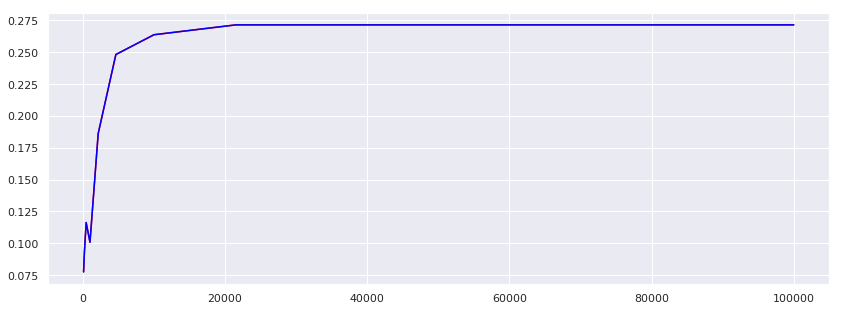

In [64]:
iters, f1s = zip(*iters_to_val)

plt.plot(iters, f1s, color='blue');

### Set max_iters = 15000

In [50]:
lr_params['max_iter'] = 15000

In [51]:
lr = LogisticRegression(**lr_params)
lr.fit(X_train, y_train)

print('F1_train:', f1_score(y_train, lr.predict(X_train), average='micro'))
print('F1_val:', f1_score(y_val, lr.predict(X_val), average='micro'))

F1_train: 1.0
F1_val: 0.2713178294573643


/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# LR with C=10, max_iter=15000

In [82]:
lr = LogisticRegression(C=10, max_iter=15000)
lr.fit(X_train, y_train)

print('Train F1:', lr.score(X_train, y_train))
print('Val F1:', f1_score(y_val, lr.predict(X_val), average='micro'))

/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bam/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Train F1: 0.9924242424242424
Val F1: 0.4728682170542635


In [83]:
print('Test F1 score is: {0:.3f}'.format(f1_score(y_test, lr.predict(X_test), average='micro')))

Test F1 score is: 0.392


# Save model for use in Flask

In [54]:
os.chdir('../flask')
os.getcwd()

'/home/bam/metis/projects/project_3/flask'

In [55]:
with open('lr.pkl', 'wb') as f:
    pickle.dump(lr, f)
    f.close()

# Get single-file identification working

In [57]:
def one_song_df(filepath):
    """Generates a 1-row DataFrame for single-song classification"""
    
    one_song_dict = dict()
    filename = filepath.split(sep='/')[-1]
    song_stats = song_dict(filepath)
    one_song_dict[filename[:-4]] = song_stats
    one_song_dict['dummy'] = song_stats
    
    one_df = pd.DataFrame.from_dict(one_song_dict, orient='index').drop('dummy')
    
    one_df['key'] = one_df['key'].map(key_dict)
    one_df = (pd.get_dummies(one_df['scale'])
                     .merge(one_df, left_index=True, right_index=True)
                     .drop(['scale', 'filepath'], axis=1))
    
    if 'minor' not in one_df.columns:
        one_df['minor'] = 0
    elif 'major' not in one_df.columns:
        one_df['major'] = 0
        
    one_df['unique_id'] = (one_df['title'] + '_'
                                    + one_df['album'] + '_'
                                    + str(one_df['semitone_offset']))
    
    return one_df

In [59]:
def predict_one(one_df):
    """Classifies a single live recording"""
    
    row = one_df.loc[one_df.index[0]]
    X_one = row[features]
    scaler.transform(np.array(X_one).reshape(1, -1))
    return lr.predict(np.array(X_one).reshape(1, -1))[0]

In [60]:
def album_name(song_name):
    """Gives album name of a studio track"""
    return all_songs[all_songs['title'] == song_name].album.values[0]

# Generate visuals
For presentation, won't work unless you setup folder structure as here

BPM: 120.70642852783203
Key: A
Scale: major


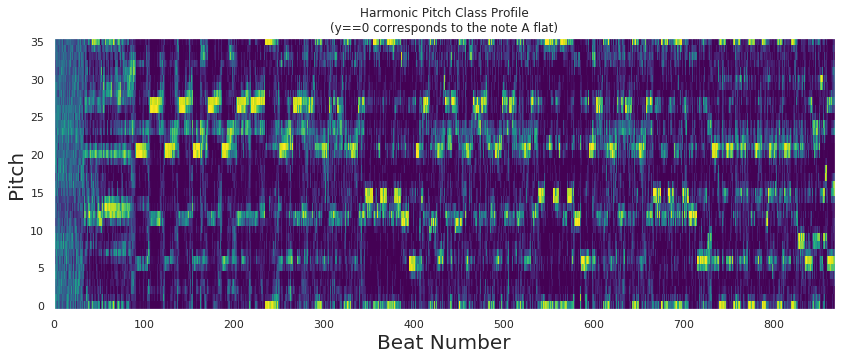

In [71]:
album_stats = song_dict('/home/bam/Music/Pink Floyd/Studio/1973 - The Dark Side Of The Moon/Pink Floyd - The Dark Side Of The Moon - 03 - Time.mp3', save_hpcp=True)
show_stats(album_stats)

BPM: 126.52445220947266
Key: A
Scale: major


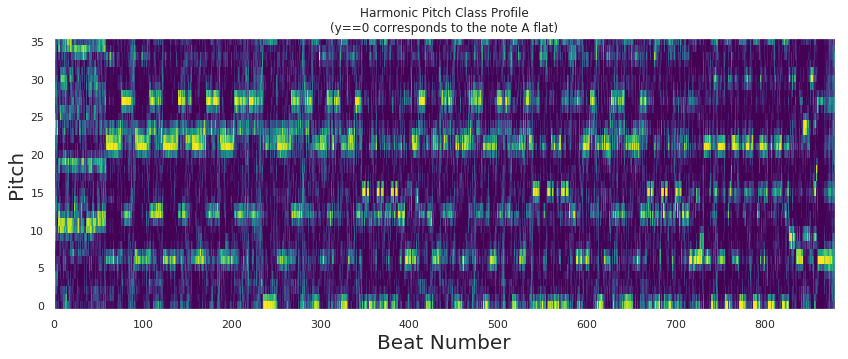

In [73]:
live_stats = song_dict('/home/bam/Music/Pink Floyd/Live/1995 - Pulse (Live)/Pink Floyd - Pulse - 04 - Time.mp3', save_hpcp=True)
show_stats(live_stats)

In [74]:
time_stats = song_dict('/home/bam/Music/Pink Floyd/Studio/1973 - The Dark Side Of The Moon/Pink Floyd - The Dark Side Of The Moon - 03 - Time.mp3', save_hpcp=True)

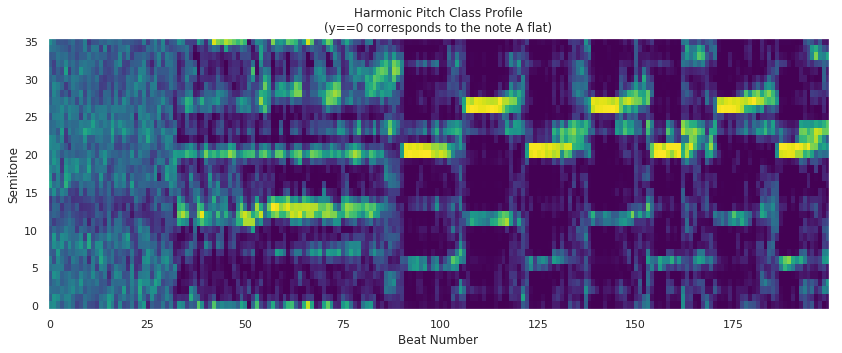

In [75]:
imshow(time_stats['hpcp'][:200, :].T, aspect='auto', origin='lower', interpolation='none', cmap='viridis')
plt.ylabel('Semitone')
plt.xlabel('Beat Number')
plt.title('Harmonic Pitch Class Profile\n(y==0 corresponds to the note A flat)')
plt.grid(b=None)
plt.show();